Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Loading original dataset from: /content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv...
✅ Successfully loaded original DataFrame 'df' with 194801 rows.
Step 3: Creating 3-class semantic labels...
Step 4: Cleaning and balancing classes...
   - Balanced 'Neutral' bin to 55092 samples (27546 of each type).
   - Balancing all classes to 55092 samples.
Step 5: Created final balanced dataset with 165276 total samples.

Verification: Makeup of Final Bins vs. Original Labels
Cross-tabulation of final data:
                  Original Negative (0)  Original Positive (1)
sentiment_3class                                              
Negative                          55092                      0
Neutral                           27546                  27546
Positive                          

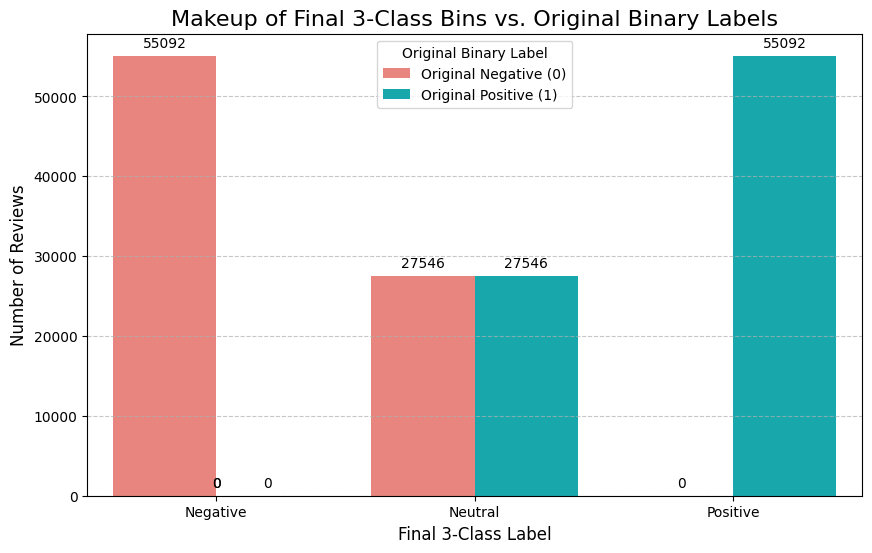


Step 8: Preparing and saving the final file...

✅ SUCCESS! Your final file has been saved to Google Drive.
Path: /content/drive/MyDrive/THESIS 47/Saved Datasets/55k data 3 class Movie review.csv

File contents (first 5 rows):
                                title  \
0           The Banshees of Inisherin   
1                        Welcome Back   
2                    The Chumscrubber   
3  Friday the 13th -- A New Beginning   
4                     Alpha and Omega   

                                          reviewText  audienceScore  \
0  A beautifully bizarre tale of wistfulness that...            7.5   
1  It's not quite as terrible as a Hangover seque...            2.6   
2  A tragic waste of acting talent, with nothing ...            7.5   
3       This one had potential but largely blows it.            2.6   
4               full review at Movies for the Masses            4.1   

   tomatoMeter  runtimeMinutes                                        genre  \
0          9.6      

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

# --- 1. Mount Google Drive ---
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    # Stop execution if mounting fails
    raise SystemExit("Google Drive mount failed. Cannot proceed.")

# Set a random seed
np.random.seed(42)

# --- 2. Load the ORIGINAL Dataset ---
# This is the path you specified
ORIGINAL_FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'
print(f"Loading original dataset from: {ORIGINAL_FILE_PATH}...")

try:
    df = pd.read_csv(ORIGINAL_FILE_PATH)
    print(f"✅ Successfully loaded original DataFrame 'df' with {len(df)} rows.")
except FileNotFoundError:
    print(f"\n--- FATAL ERROR ---")
    print(f"Original file not found at: {ORIGINAL_FILE_PATH}")
    print("Please check the file path and name and try again.")
    raise
except Exception as e:
    print(f"\nAn error occurred while loading the original file: {e}")
    raise

# --- 3. Create 3-Class Semantic Labels ---
print("Step 3: Creating 3-class semantic labels...")
# Drop rows where 'originalScore' or 'sentiment_label' is NaN, as they will cause errors
df = df.dropna(subset=['originalScore', 'sentiment_label'])

bin_edges = [0, 5, 7, 11]
class_names_3 = ["Negative", "Neutral", "Positive"]

df['sentiment_3class'] = pd.cut(
    df['originalScore'], bins=bin_edges, labels=class_names_3,
    right=False, include_lowest=True
)
# Ensure 'label' column is created as integer 0, 1, 2
df['label'] = LabelEncoder().fit_transform(df['sentiment_3class'])

# --- 4. Clean & Balance Classes (as you requested) ---
print("Step 4: Cleaning and balancing classes...")
# Clean Negative bin
df_neg_clean = df[
    (df['sentiment_3class'] == 'Negative') & (df['sentiment_label'] == 0)
].copy()

# Clean Positive bin
df_pos_clean = df[
    (df['sentiment_3class'] == 'Positive') & (df['sentiment_label'] == 1)
].copy()

# Balance Neutral bin
neutral_neg = df[(df['sentiment_3class'] == 'Neutral') & (df['sentiment_label'] == 0)].copy()
neutral_pos = df[(df['sentiment_3class'] == 'Neutral') & (df['sentiment_label'] == 1)].copy()
n_balanced_neutral = min(len(neutral_neg), len(neutral_pos))

neutral_neg_sampled = neutral_neg.sample(n=n_balanced_neutral, random_state=42)
neutral_pos_sampled = neutral_pos.sample(n=n_balanced_neutral, random_state=42)
df_neu_balanced = pd.concat([neutral_pos_sampled, neutral_neg_sampled])
print(f"   - Balanced 'Neutral' bin to {n_balanced_neutral*2} samples ({n_balanced_neutral} of each type).")

# Balance all three to the smallest group size
min_size = min(len(df_neg_clean), len(df_pos_clean), len(df_neu_balanced))
print(f"   - Balancing all classes to {min_size} samples.")

df_neg_final = df_neg_clean.sample(n=min_size, random_state=42)
df_pos_final = df_pos_clean.sample(n=min_size, random_state=42)
df_neu_final = df_neu_balanced.sample(n=min_size, random_state=42)

# --- 5. Create Final DataFrame (for EDA) ---
df_final_eda = pd.concat([df_neg_final, df_pos_final, df_neu_final])
df_final_eda = df_final_eda.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Step 5: Created final balanced dataset with {len(df_final_eda)} total samples.")

# ============================================================
# --- 6. EDA & VERIFICATION (The check you wanted) ---
# ============================================================
print("\n" + "="*60)
print("Verification: Makeup of Final Bins vs. Original Labels")
print("="*60)

# Create the cross-tabulation
crosstab_eda = pd.crosstab(
    df_final_eda['sentiment_3class'],
    df_final_eda['sentiment_label']
)
crosstab_eda.columns = ['Original Negative (0)', 'Original Positive (1)']
print("Cross-tabulation of final data:")
print(crosstab_eda)
print("="*60)

# --- 7. Plot the Graph ---
print("Generating graph...")

# Prepare data for plotting
plot_data = crosstab_eda.reset_index().melt(
    id_vars='sentiment_3class',  # Corrected from 'index'
    var_name='Original Label',
    value_name='Count'
)
plot_data = plot_data.rename(columns={'sentiment_3class': 'New 3-Class Label'})

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_data,
    x='New 3-Class Label',
    y='Count',
    hue='Original Label',
    palette={'Original Negative (0)': '#F8766D', 'Original Positive (1)': '#00BFC4'}
)
plt.title('Makeup of Final 3-Class Bins vs. Original Binary Labels', fontsize=16)
plt.xlabel('Final 3-Class Label', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Original Binary Label')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# Save the plot to your Drive as well
plot_save_path = '/content/drive/MyDrive/THESIS 47/Saved Datasets/final_data_makeup_plot.png'
plt.savefig(plot_save_path)
print(f"   - Saved verification plot to {plot_save_path}")
plt.show()

# --- 8. Prepare and Save the FINAL File (with sentiment_label) ---
print("\nStep 8: Preparing and saving the final file...")

# We ONLY drop 'originalScore' and the temporary 'sentiment_3class'
# We KEEP 'sentiment_label'
columns_to_drop = ['originalScore', 'sentiment_3class']
df_to_save = df_final_eda.drop(columns=columns_to_drop)

# Rename 'label' (0,1,2) to '3 class label'
df_to_save = df_to_save.rename(columns={'label': '3 class label'})

# Move '3 class label' to be the last column, as you asked
cols_to_move = ['sentiment_label', '3 class label']
cols = [col for col in df_to_save.columns if col not in cols_to_move] + cols_to_move
df_to_save = df_to_save[cols]

# Define save path
SAVE_DIR = '/content/drive/MyDrive/THESIS 47/Saved Datasets'
FILE_NAME = '55k data 3 class Movie review.csv'
SAVE_PATH = os.path.join(SAVE_DIR, FILE_NAME)

try:
    os.makedirs(SAVE_DIR, exist_ok=True)
    df_to_save.to_csv(SAVE_PATH, index=False)

    print("\n" + "="*60)
    print("✅ SUCCESS! Your final file has been saved to Google Drive.")
    print(f"Path: {SAVE_PATH}")
    print("\nFile contents (first 5 rows):")
    print(df_to_save.head())
    print("\nFinal file columns:")
    print(df_to_save.columns.tolist())
    print("="*60)

except Exception as e:
    print(f"\nAn error occurred while saving the file: {e}")

print("--- Script Finished ---")

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# --- 1. Mount Drive and Load the Dataset ---
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Error mounting Drive: {e}")
    raise SystemExit("Drive mount failed.")

# Define the path to the file you just saved
FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/55k data 3 class Movie review.csv'
print(f"Loading dataset from: {FILE_PATH}...")

try:
    # Load the new, clean dataset
    df_new = pd.read_csv(FILE_PATH)
    print("✅ File loaded successfully.")
except Exception as e:
    print(f"Error loading file: {e}")
    raise SystemExit("File not found. Please run the previous script first.")

# --- 2. Initial EDA: Check Columns and Data ---
print("\n" + "="*60)
print("Verifying Columns (EDA: .info())")
print("="*60)
print("This confirms 'sentiment_label' and '3 class label' are both present.")
df_new.info()

print("\n" + "="*60)
print("Verifying Data (EDA: .head())")
print("="*60)
print(df_new.head())

Mounted at /content/drive
Loading dataset from: /content/drive/MyDrive/THESIS 47/Saved Datasets/55k data 3 class Movie review.csv...
✅ File loaded successfully.

Verifying Columns (EDA: .info())
This confirms 'sentiment_label' and '3 class label' are both present.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165276 entries, 0 to 165275
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   title             165276 non-null  object 
 1   reviewText        165276 non-null  object 
 2   audienceScore     165276 non-null  float64
 3   tomatoMeter       165276 non-null  float64
 4   runtimeMinutes    164874 non-null  float64
 5   genre             165273 non-null  object 
 6   language_encoded  165276 non-null  int64  
 7   director_encoded  165276 non-null  int64  
 8   sentiment_label   165276 non-null  int64  
 9   3 class label     165276 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory u

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# We assume 'df_new' is loaded in memory from the previous cell.

print("\n" + "="*60)
print("EDA: Makeup of New Bins vs. Original Binary Labels")
print("="*60)

# Create the cross-tabulation (what you asked for)
# We use the integer labels: 0=Neg, 1=Neu, 2=Pos
crosstab_check = pd.crosstab(
    df_new['3 class label'],
    df_new['sentiment_label']
)
crosstab_check.columns = ['Original Negative (0)', 'Original Positive (1)']
crosstab_check.index = ['Negative (0)', 'Neutral (1)', 'Positive (2)']

print("Cross-tabulation of final data:")
print(crosstab_check)
print("="*60)


EDA: Makeup of New Bins vs. Original Binary Labels
Cross-tabulation of final data:
              Original Negative (0)  Original Positive (1)
Negative (0)                  55092                      0
Neutral (1)                   27546                  27546
Positive (2)                      0                  55092



Generating graph of the data makeup...


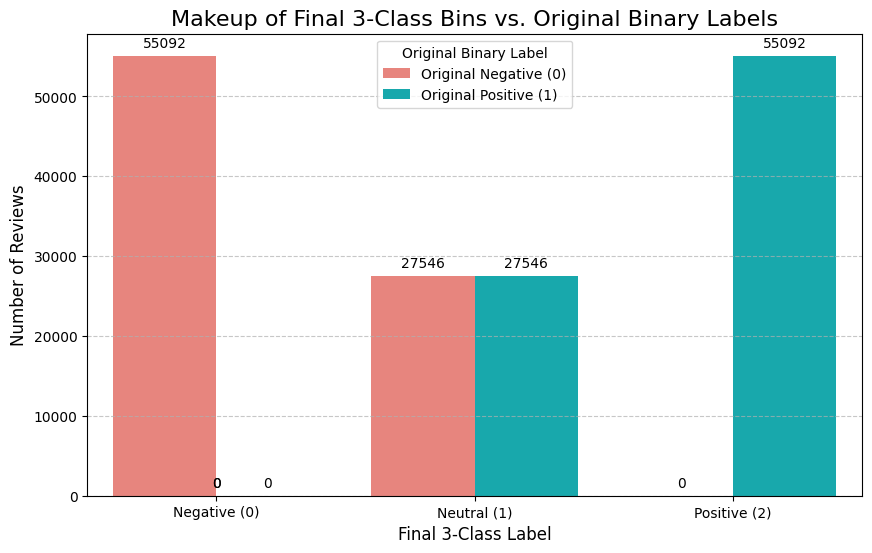

In [9]:
# --- Plot the Graph ---
print("\nGenerating graph of the data makeup...")

# Prepare data for plotting
plot_data = crosstab_check.reset_index().melt(
    id_vars='index',
    var_name='Original Label',
    value_name='Count'
)
plot_data = plot_data.rename(columns={'index': 'New 3-Class Label'})

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_data,
    x='New 3-Class Label',
    y='Count',
    hue='Original Label',
    palette={'Original Negative (0)': '#F8766D', 'Original Positive (1)': '#00BFC4'}
)
plt.title('Makeup of Final 3-Class Bins vs. Original Binary Labels', fontsize=16)
plt.xlabel('Final 3-Class Label', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Original Binary Label')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()